In [1]:
# DL framework
import tensorflow as tf

from datetime import datetime

# common packages
import numpy as np
import os
import math

# timing epochs
import time

# read image
from imageio import imread

# plotting pretty figures
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

# const
SEED = 42

# Helper to make the output consistent
def reset_graph(seed=SEED):
    tf.reset_default_graph()
    tf.set_random_seed(seed)
    np.random.seed(seed)

    
# set log level to supress messages, unless an error
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

# Check TensorFlow version
print('TensorFlow Version: {}'.format(tf.__version__))

# Check if using GPU
if not tf.test.gpu_device_name():
    print('No GPU found')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))
    
reset_graph()

TensorFlow Version: 1.6.0-dev20180105
No GPU found


In [2]:
SQUARE_DIM = 224
if SQUARE_DIM:
    IMG_WIDTH = SQUARE_DIM
    IMG_HEIGHT = SQUARE_DIM
    
CHANNELS = 3

In [3]:
# preprocessing
def prep_image(image, target_width = IMG_WIDTH, target_height = IMG_HEIGHT, TRAINING=False,
               centerCrop = True, lrf_p=0.0, upf_p=0.0, r_degree=0.0):
    
    if centerCrop:
        #image = tf.image.central_crop(image, central_fraction=0.5)
        
        image_shape = tf.cast(tf.shape(image), tf.float32)
        height = image_shape[0]
        width = image_shape[1]
        image_ratio = width / height
        target_image_ratio = target_width / target_height
        
        # crop to square
        crop_vertically = image_ratio < target_image_ratio
        crop_width = tf.cond(crop_vertically,
                             lambda: width,
                             lambda: height * target_image_ratio)
        crop_height = tf.cond(crop_vertically,
                              lambda: width / target_image_ratio,
                              lambda: height)
        
        crop_width = tf.cast(crop_width, tf.float32)
        crop_height = tf.cast(crop_height, tf.float32)
        wStart = tf.cast((width - crop_width)/2, tf.int32)
        hStart = tf.cast((height - crop_height)/2,tf.int32)

        # center crop coordinates
        x0 = wStart
        y0 = hStart
        x1 = x0 + tf.cast(crop_width, tf.int32)
        y1 = y0 + tf.cast(crop_height, tf.int32)

        # Crop the image using the bounding box
        image = tf.image.crop_to_bounding_box(image, y0, x0, y1, x1)
        #image = image[y0:y1, x0:x1]
    
    
#     # augment only on training images.   
#     if TRAINING:
#         # Flip the image horizontally with lrf_p% probability:
#         if np.random.rand() < lrf_p:
#             image = tf.image.flip_left_right(image)

#         # Flip the image vertically with upf_p% probability:
#         if np.random.rand() < upf_p:
#             image = tf.image.flip_up_down(image)

    
    # default = method=ResizeMethod.BILINEAR
    image_batch = tf.expand_dims(image, 0)
    image = tf.image.resize_bilinear(image_batch, [target_height, target_width])[0]
    
#     if TRAINING:
#         # Rotate, last, the image
#         if r_degree > 0:
#             r_degree *= np.random.rand()
#             # randomly choose rotation direction
#             r_dir = (1 if np.random.rand() > 0.5 else -1)
#             r_degree *= r_dir
#             print(r_degree, r_dir)
#             image = tf.contrib.image.rotate(image, r_degree, interpolation='NEAREST')

    return image

In [4]:
## set up inputs
melanoma_path = "/home/jack/code/python/github/improving_classification_with_GAN/dataset/s_melanoma"
melanoma_LABEL = 1
benign_path = "/home/jack/code/python/github/improving_classification_with_GAN/dataset/s_benign"
benign_LABEL = 0
# [benign, melanoma] --> [0, 1]

# melanoma_path = "/home/jack/code/python/github/improving_classification_with_GAN/dataset/pet_set/dog"
# melanoma_LABEL = 1
# benign_path = "/home/jack/code/python/github/improving_classification_with_GAN/dataset/pet_set/cat"
# benign_LABEL = 0

In [5]:
path_list_melanoma = []
for _, _, files in os.walk(melanoma_path):
    for filename in files:
        path_list_melanoma.append(filename)

path_list_benign = []
for _, _, files in os.walk(benign_path):
    for filename in files:
        path_list_benign.append(filename)

# sort images by filename
path_list_melanoma = sorted(path_list_melanoma)
path_list_benign = sorted(path_list_benign)

# print dataset information
total_instances_n = len(path_list_benign) + len(path_list_melanoma)
print("benign:", len(path_list_benign), "melanoma:", len(path_list_melanoma), " total =", total_instances_n)

benign: 2696 melanoma: 858  total = 3554


In [6]:
# obtain n ids of the larger class
small_b = np.random.choice(range(len(path_list_benign)),len(path_list_melanoma), replace=False)
print(len(small_b))

858


In [7]:
# convert the random indexes to a list of ids
balanced_path_list_benign = []
for b in small_b:
    balanced_path_list_benign.append(path_list_benign[b])

print(len(balanced_path_list_benign))

858


In [8]:
# sort images by filename
path_list_melanoma = sorted(path_list_melanoma)
path_list_benign = sorted(balanced_path_list_benign)

# print dataset information
total_instances_n = len(path_list_benign) + len(path_list_melanoma)
print("benign:", len(path_list_benign), "melanoma:", len(path_list_melanoma), " total =", total_instances_n)

benign: 858 melanoma: 858  total = 1716


In [9]:
# create empty place holders
X_in = np.zeros((total_instances_n, IMG_WIDTH, IMG_HEIGHT, 3), dtype='float32')
# y_in = np.zeros((total_instances_n, 2))
y_in = np.zeros((total_instances_n, 1))
print("img_shape: ", X_in[0].shape)
print("label_shape: ", y_in[0].shape)

img_shape:  (224, 224, 3)
label_shape:  (1,)


In [10]:
input_image = tf.placeholder(tf.uint8, shape=[None, None, 3])
prep_image_op = prep_image(input_image)

index = 0
with tf.Session() as sess:
    for f in path_list_melanoma:
        img = imread(os.path.join(melanoma_path, f))
        prepared_image = prep_image_op.eval(feed_dict={input_image: img})
        X_in[index] = prepared_image
        #y_in[index] = [0, 1]
        y_in[index] = melanoma_LABEL
        index += 1
        if index % 20 == 0:
            print(index)
        
    for f in path_list_benign:
        img = imread(os.path.join(benign_path, f))
        prepared_image = prep_image_op.eval(feed_dict={input_image: img})
        X_in[index] = prepared_image
        #y_in[index] = [1, 0]
        y_in[index] = benign_LABEL
        index += 1
        if index % 20 == 0:
            print(index)

20
40
60
80
100
120
140
160
180
200
220
240
260
280
300
320
340
360
380
400
420
440
460
480
500
520
540
560
580
600
620
640
660
680
700
720
740
760
780
800
820
840
860
880
900
920
940
960
980
1000
1020
1040
1060
1080
1100
1120
1140
1160
1180
1200
1220
1240
1260
1280
1300
1320
1340
1360
1380
1400
1420
1440
1460
1480
1500
1520
1540
1560
1580
1600
1620
1640
1660
1680
1700


[ 0.]


(-0.5, 223.5, 223.5, -0.5)

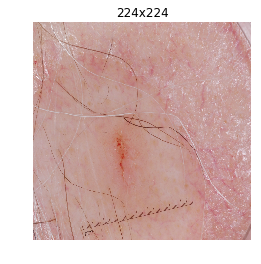

In [11]:
image = X_in[1500]
label = y_in[1500]
print(label)
plt.imshow(image.astype(np.uint8),interpolation="nearest")
plt.title("{}x{}".format(image.shape[1], image.shape[0]))
plt.axis("off")

In [13]:
# initial shuffle
from sklearn.utils import shuffle
X_in, y_in = shuffle(X_in, y_in, random_state=42)

In [14]:
from sklearn.model_selection import StratifiedShuffleSplit
split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)

In [15]:
for train_index, test_index in split.split(X_in, y_in):
    train_set_x = X_in[train_index]
    strat_test_set_x = X_in[test_index]
    train_set_y = y_in[train_index]
    strat_test_set_y = y_in[test_index]

In [16]:
print(len(strat_test_set_y))
print(len(strat_test_set_x))

344
344


[ 0.]


(-0.5, 223.5, 223.5, -0.5)

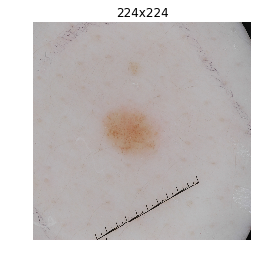

In [17]:
image = strat_test_set_x[15]
label = strat_test_set_y[15]
print(label)
plt.imshow(image.astype(np.uint8),interpolation="nearest")
plt.title("{}x{}".format(image.shape[1], image.shape[0]))
plt.axis("off")

In [18]:
for train_index, val_index in split.split(train_set_x, train_set_y):
    strat_train_set_x = train_set_x[train_index]
    strat_val_set_x = train_set_x[val_index]
    strat_train_set_y = train_set_y[train_index]
    strat_val_set_y = train_set_y[val_index]

In [19]:
print("train:", "X", strat_train_set_x.shape[0], "y", strat_train_set_y.shape[0])
print("val:", "X", strat_val_set_x.shape[0], "y", strat_val_set_y.shape[0])
print("test:", "X", strat_test_set_x.shape[0], "y", strat_test_set_y.shape[0])

train: X 1097 y 1097
val: X 275 y 275
test: X 344 y 344


In [20]:
print("train-----")
y1 = 0
y0 = 0
for y in strat_train_set_y:
    if y == 1:
        y1 += 1
    elif y == 0:
        y0 += 1
print(y1)
print(y0)

print("val-----")
y1 = 0
y0 = 0
for y in strat_val_set_y:
    if y == 1:
        y1 += 1
    elif y == 0:
        y0 += 1
print(y1)
print(y0)

print("test-----")
y1 = 0
y0 = 0
for y in strat_test_set_y:
    if y == 1:
        y1 += 1
    elif y == 0:
        y0 += 1
print(y1)
print(y0)

train-----
549
548
val-----
137
138
test-----
172
172


[ 1.]


(-0.5, 223.5, 223.5, -0.5)

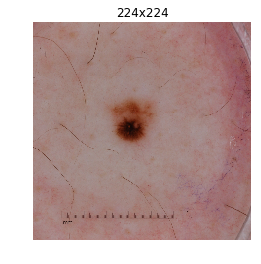

In [21]:
num = 3
image = strat_train_set_x[num]
label = strat_train_set_y[num]
print(label)
plt.imshow(image.astype(np.uint8),interpolation="nearest")
plt.title("{}x{}".format(image.shape[1], image.shape[0]))
plt.axis("off")

In [22]:
# utility plotting function
def plot_color_image(image):
    plt.imshow(image.astype(np.uint8),interpolation="nearest")
    plt.title("{}x{}".format(image.shape[1], image.shape[0]))
    plt.axis("off")

[ 0.]


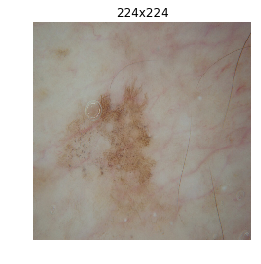

In [23]:
num = 51
image = strat_val_set_x[num]
label = strat_val_set_y[num]
print(label)
plot_color_image(image)

In [25]:
np.save('./numpy/sigmoid/lesion/' + str(SQUARE_DIM) + '/X_train.npy', strat_train_set_x)
np.save('./numpy/sigmoid/lesion/' + str(SQUARE_DIM) + '/y_train.npy', strat_train_set_y)

np.save('./numpy/sigmoid/lesion/' + str(SQUARE_DIM) + '/X_val.npy', strat_val_set_x)
np.save('./numpy/sigmoid/lesion/' + str(SQUARE_DIM) + '/y_val.npy', strat_val_set_y)

np.save('./numpy/sigmoid/lesion/' + str(SQUARE_DIM) + '/X_test.npy', strat_test_set_x)
np.save('./numpy/sigmoid/lesion/' + str(SQUARE_DIM) + '/y_test.npy', strat_test_set_y)